In [1]:
import sintel_io
import numpy as np
import scipy.linalg as linalg
import itertools
from JSAnimation import IPython_display
import matplotlib.pyplot as plt
from matplotlib import animation
from multiprocessing import Pool, Manager, Process,TimeoutError
import time
import os
from mpl_toolkits.mplot3d import Axes3D

In [2]:
TAG_FLOAT = 202021.25
TAG_CHAR = 'PIEH'
def flow_read(filename):
    """ Read optical flow from file, return (U,V) tuple. 
    
    Original code by Deqing Sun, adapted from Daniel Scharstein.
    """
    f = open(filename,'rb')
    check = np.fromfile(f,dtype=np.float32,count=1)[0]
    assert check == TAG_FLOAT, ' flow_read:: Wrong tag in flow file (should be: {0}, is: {1}). Big-endian machine? '.format(TAG_FLOAT,check)
    width = np.fromfile(f,dtype=np.int32,count=1)[0]
    height = np.fromfile(f,dtype=np.int32,count=1)[0]
    size = width*height
    assert width > 0 and height > 0 and size > 1 and size < 100000000, ' flow_read:: Wrong input size (width = {0}, height = {1}).'.format(width,height)
    tmp = np.fromfile(f,dtype=np.float32,count=-1).reshape((height,width*2))
    u = tmp[:,np.arange(width)*2]
    v = tmp[:,np.arange(width)*2 + 1]
    return u,v

In [3]:
v_x, v_y = flow_read("./data/other-gt-flow/Grove2/flow10.flo")

In [4]:
size = np.shape(v_x)

(480, 640)


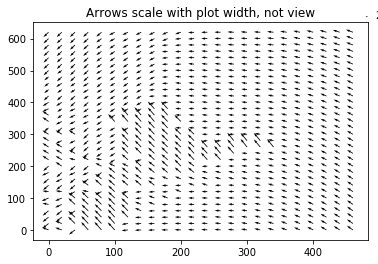

In [5]:
%matplotlib inline
X,Y = np.meshgrid(np.arange(0,size[0],20),np.arange(0,size[1],20))
print(size)
plt.figure()
plt.title('Arrows scale with plot width, not view')
Q = plt.quiver(X, Y, v_x[X,Y], v_y[X,Y], units='width')
qk = plt.quiverkey(Q, 0.9, 0.9, 0.9, r'$2 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')

In [17]:
x_lim = size[0]
y_lim = size[1]
N = 8 #number of random points in each patch
f = 15 #focal length
patch1d = 3
num_patches = 0

im_patches = np.transpose([[np.random.randint(0,10,size=N),np.random.randint(0,10,size=N)]])
for x_split in np.arange(0,patch1d*np.int(x_lim/patch1d),np.int(x_lim/patch1d)):
    for y_split in np.arange(0,patch1d*np.int(y_lim/patch1d),np.int(y_lim/patch1d)):
        sample_points = np.transpose([np.random.randint(x_split,x_split+np.int(x_lim/patch1d),size=N),np.random.randint(y_split,y_split+np.int(y_lim/patch1d),size=N)])
        im_patches = np.dstack((im_patches,sample_points))
        num_patches += 1
im_patches = im_patches[:,:,1:]

In [18]:
#delegating all of these to a file might be helpful

def calculate_CT(sample_points, T): #input the presampled points
    N = np.shape(sample_points)[0]; #justincase
    A_T = np.zeros([2*N,N]) #preallocate ndarrays for storing the matrices
    B = np.zeros([2*N,3])
    
    for i in np.arange(0,N,1):
        x,y = sample_points[i,0],sample_points[i,1]
        xscaled = x - (size[0]/2)
        yscaled = y - (size[1]/2)
        
        #calculating A_T
        A = np.array([[-f,0,xscaled],[0,-f,yscaled]])
        AtimesT = np.dot(A,T)
        A_T[2*i,i], A_T[2*i+1,i] = AtimesT[0], AtimesT[1]
        
        #calculating B
        B[2*i] = np.array([(xscaled*yscaled)/f, -(f + (xscaled*xscaled)/f), yscaled])
        B[2*i+1] = np.array([f + (yscaled*yscaled)/f, -(xscaled*yscaled)/f, -xscaled])
    
    return np.concatenate((A_T,B),axis=1)

def calculate_projected_CT(sample_points,T):
    N = np.shape(sample_points)[0]; #justincase
    CT = calculate_CT(sample_points,T)
    CTbar, r = np.linalg.qr(CT)
    I = np.identity(2*N)
    cc = np.dot(CTbar,np.transpose(CTbar))
    return (I - cc)

def calculate_v(sample_points):
    sample_v_x, sample_v_y = v_x[sample_points[:,0],sample_points[:,1]], v_y[sample_points[:,0],sample_points[:,1]]
    v = np.vstack((sample_v_x,sample_v_y)).reshape((-1),order='F').reshape(2*N,1)
    return v

def calculate_CT_parallel_inner(params):
    idtheta, idphi,patch_id = params[0],params[1],params[2]
    theta,phi = idtheta/100,idphi/100
    x = np.cos(theta)*np.sin(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(phi)
    T = np.array([[x],[y],[z]])
    sample_points = im_patches[:,:,patch_id]
    projected_CT = calculate_projected_CT(sample_points,T) #the time consumer
    np.save('ct_estimate/ct_estimate_patchid{}_idtheta{}_idphi{}.npy'.format(patch_id,idtheta,idphi),projected_CT)

    
## if time permits, try double optimisations, but remember that daemonic processes cannnot have children
## that was called calculate_CT_parallel_outer, and hence the moniker inner above

def calculate_E(params): #tentative, check use of sample_points, T or using patch_no, phi, theta
    idtheta, idphi, patch_id = params[0],params[1],params[2]    
    sample_points = im_patches[:,:,patch_id]
    projected_CT = np.load('ct_estimate/ct_estimate_patchid{}_idtheta{}_idphi{}.npy'.format(patch_id,idtheta,idphi))
    v = calculate_v(sample_points)
    E_T = (np.linalg.norm(np.dot(projected_CT,v)))**2
    return (patch_id,idtheta,idphi,E_T)
    

In [19]:
%%time
##this is to be ran only once at the beginning of the video
CPU_NUMBER = os.cpu_count()
if __name__ == '__main__':
    search_range = np.arange(0,np.int(100*np.pi),1)
    patch_id_range = range(num_patches)
    paramlist = list(itertools.product(search_range,search_range,patch_id_range))
    pool = Pool(CPU_NUMBER)
    pool.map(calculate_CT_parallel_inner,paramlist)

CPU times: user 5.19 s, sys: 2.19 s, total: 7.38 s
Wall time: 16min 6s


In [20]:
%%time

## this is to be run as the video runs - repeatedly
CPU_NUMBER = os.cpu_count()
if __name__=='__main__':
    search_range = np.arange(0,np.int(100*np.pi),1)
    patch_id_range = range(num_patches)
    paramlist = list(itertools.product(search_range,search_range,patch_id_range))
    pool = Pool()
    res = pool.map(calculate_E,paramlist)

CPU times: user 5.09 s, sys: 2.85 s, total: 7.94 s
Wall time: 13min 29s


In [21]:
E = np.zeros((np.size(search_range),np.size(search_range)))
for item in res:
    E[item[1],item[2]] = E[item[1],item[2]] +  item[3]
    


266 150
[[-0.88403825]
 [ 0.46203096]
 [ 0.0707372 ]]


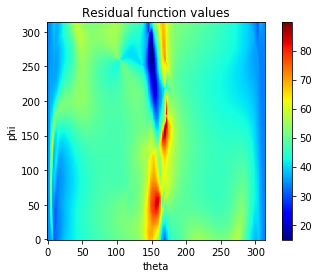

In [22]:
#plotting residual surfaces
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('theta')
ax.set_ylabel('phi')
im = ax.imshow(E, cmap="jet",origin = "lower")
fig.colorbar(im)
ax.set_title('Residual function values')
plt.savefig('figs/res_depth.png',bbox_inches='tight')
idtheta, idphi = np.unravel_index(E.argmin(), E.shape)
print(idtheta,idphi)
theta, phi = idtheta/100, idphi/100
x_final = np.cos(theta)*np.sin(phi)
y_final = np.sin(theta)*np.sin(phi)
z_final = np.cos(phi)
T_final = np.array([[x_final],[y_final],[z_final]])
print(T_final)

In [23]:
%%time
#estimating rotation given the translation
N = np.shape(sample_points)[0]; #justincase
f = 15
sum_left = np.zeros([3,3])
sum_right = np.zeros([3,1])

for time in np.arange(20,21,1):
    for i in np.arange(0,N,1):
        x,y = sample_points[i,0],sample_points[i,1]
        xscaled = x - (size[0]/2)
        yscaled = y - (size[1]/2)
        #calculating d
        A = np.array([[-f,0,xscaled],[0,-f,yscaled]])
        AtimesT = np.dot(A,T_final)
        d = np.array([[AtimesT[1,0]],[-AtimesT[0,0]]])
        di = d/linalg.norm(d)

        #calculating left term in omega estimate
        Bi = np.array([[(xscaled*yscaled)/f, -(f + (xscaled*xscaled)/f), yscaled],[f + (yscaled*yscaled)/f, -(xscaled*yscaled)/f, -xscaled]])
        sum_left += np.dot(np.transpose(Bi),np.dot(di,np.dot(np.transpose(di),Bi)))
        
        #calculating right term in omega estimate
        sample_v_x,sample_v_y = v_x[x,y],v_y[x,y]
        vi = np.array([[sample_v_x],[sample_v_y]])
        sum_right += np.dot(np.transpose(Bi),np.dot(di,np.dot(np.transpose(di),vi)))

omega = np.dot(linalg.inv(sum_left),sum_right)
print(omega)

[[ 0.00015823]
 [-0.00021229]
 [-0.00461844]]
CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 959 ms


In [24]:
#calculating depth
depth_mat0 = np.zeros([x_lim,y_lim])
depth_mat1 = np.zeros([x_lim,y_lim])
print(T_final)
print(omega)
for x in np.arange(0,x_lim,1):
    for y in np.arange(0,y_lim,1):
        xscaled = x - (size[0]/2)
        yscaled = y - (size[1]/2)
        A = np.array([[-f,0,xscaled],[0,-f,yscaled]])
        B = np.array([[(xscaled*yscaled)/f, -(f + (xscaled*xscaled)/f), yscaled],[f + (yscaled*yscaled)/f, -(xscaled*yscaled)/f, -xscaled]])
        v = np.array([[v_x[x,y]],[v_y[x,y]]])
        scaled_AT = v - np.dot(B,omega)
        act_AT = np.dot(A,T_final)
        depth0 = (act_AT/scaled_AT)[0]
        depth1 = (act_AT/scaled_AT)[1]
        depth_mat0[x,y] = depth0
        depth_mat1[x,y] = depth1


[[-0.88403825]
 [ 0.46203096]
 [ 0.0707372 ]]
[[ 0.00015823]
 [-0.00021229]
 [-0.00461844]]


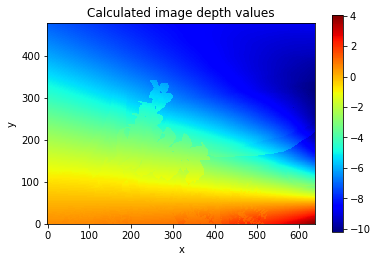

In [25]:
#plotting depth
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('x')
ax.set_ylabel('y')
im = ax.imshow(depth_mat0, cmap="jet",origin = "lower")
fig.colorbar(im)
ax.set_title('Calculated image depth values')
plt.savefig('figs/calculated_depth.png', bbox_inches='tight')
